
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Preprocessing:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

In here, we add a separator token "sep". It will serve to indicate when a utteration is over, and another one starts. We also add a padding token at the end to ensure that all inputs have same dimention.


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
! pip install requests json
# eventually include tensorboard

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import gensim
import json
import requests
import heapq

from nltk.tokenize import TweetTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import pandas as pd
import numpy as np

In [3]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-01-23 09:49:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.52.45, 18.164.52.25, 18.164.52.20, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.52.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  30.4MB/s    in 24s     

2025-01-23 09:49:28 (27.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
## taken from template
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary = False)

In [5]:
## We create the embeddings and find the vocab
import copy
unk_token, sep_token = '<unk>', '<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors) ## TODO: remove least frequent
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [unk_token,sep_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))

In [6]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

max_size = 50
## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  return text, [emotion]*len(text)

def concat_utt(dialog, emotions, stoi): ## list of utterations : [string] -> list of list of tokenized words : [int]
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog = [i[0] for i in tokenized_and_extended]
  emotions = [i[1] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = []
  for i in range(len(dialog) - 1):
    dialog[i].append(stoi["<sep>"])
    emotions[i].append(7) ## number of emotions
  for i in range(len(dialog)):
    dialog_flat.extend(dialog[i])
    emotions_extended.extend(emotions[i])
  return dialog_flat,emotions_extended

def preprocess_data(X,Y,stoi): ## list of lists of utterations : [[string]] -> list of lists of tokenized words : [[int]]
  X_processed = []
  Y_processed = []
  for i in tqdm(range(len(X))):
    X_processed.append(concat_utt(X[i],Y[i],stoi)[0])
    Y_processed.append(concat_utt(X[i],Y[i],stoi)[1])
  return X_processed, Y_processed

def get_target(X,Y): ## generates the target values and input values
  text_input = [i[:-1] for i in X]
  text_target = [i[1:] for i in X]
  emotion_input = [i[:-1] for i in Y]
  emotion_target = [i[1:] for i in Y]
  return text_input, text_target, emotion_input, emotion_target


## Check the following example:
dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = [1,2] ## random emotions...

flatten_dialog, flatten_emotions = concat_utt(dialog_example,emotions_example,stoi)
print(f"{dialog_example} becomes {flatten_dialog}")
print(f"{emotions_example} becomes {flatten_emotions}")


['hello, I am a I robot!', 'I am greek'] becomes [13171, 2, 30, 783, 9, 30, 6871, 79, 1, 30, 783, 22504]
[1, 2] becomes [1, 1, 1, 1, 1, 1, 1, 1, 7, 2, 2, 2]


## DataLoader not implemented yet:

In [7]:
## Modify this after changing the preprocessing.
class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class MeldDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for MELD dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class EmorynlpDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
    # Dataset object for EmoryNLP dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                 'texts': np.array(self.texts[idx]),
              'emotions': np.array(self.emotions[idx]),
          'target_texts': np.array(self.target_texts[idx]),
      'target_emotions' : np.array(self.target_emotions[idx])
    }
    return item


Here we will extract the data and process it:

In [8]:
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/train_sent_emo.csv

--2025-01-23 09:52:30--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121640 (119K) [text/plain]
Saving to: ‘dev_sent_emo.csv.5’

dev_sent_emo.csv.5  100%[===================>] 118.79K  --.-KB/s    in 0.02s   

2025-01-23 09:52:30 (5.68 MB/s) - ‘dev_sent_emo.csv.5’ saved [121640/121640]

--2025-01-23 09:52:30--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respo

In [9]:
#data_dd = load_dataset('daily_dialog') ## daily conversations

data_meld_train = pd.read_csv('train_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_val = pd.read_csv('dev_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_test = pd.read_csv('test_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])

## For Daily Dialog:
"""
X_train_dd = data_dd['train']['dialog']
Y_train_dd = data_dd['train']['emotion']
X_test_dd = data_dd['test']['dialog']
Y_test_dd = data_dd['test']['emotion']
X_val_dd = data_dd['validation']['dialog']
Y_val_dd = data_dd['validation']['emotion']
"""
## For MELD
def change_Y(Y,lookup=None):
  lookup = {} if lookup is None else lookup
  k = 0
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      if Y[i][j] not in lookup:
        lookup[Y[i][j]] = k
        Y[i][j] = k
        k += 1
      else:
        Y[i][j] = lookup[Y[i][j]]
  return Y, lookup


def parse_meld(df,lookup = None):
  X, Y = {}, {}
  for _, row in df.iterrows():
    dialog_id = row['Dialogue_ID']
    if dialog_id not in X:
      X[dialog_id] = []
      Y[dialog_id] = []
    X[dialog_id].append(row['Utterance'])
    Y[dialog_id].append(row['Emotion'])
  X = list(X.values())
  Y = list(Y.values())
  Y,lookup = change_Y(Y,lookup)
  return X, Y, lookup

X_train_meld, Y_train_meld, lookup_meld = parse_meld(data_meld_train)
X_test_meld, Y_test_meld, _ = parse_meld(data_meld_test,lookup_meld)
X_val_meld, Y_val_meld, _ = parse_meld(data_meld_val,lookup_meld)


## For EmoryNLP:
def parse_seasons(episodes,lookup=None): ## annoying parsing
  lookup = {} if lookup is None else lookup
  X = []
  Y = []
  for episode in episodes:
    for scene in episode['scenes']:
      dialog = []
      emotion = []
      for utterance in scene['utterances']:
        if utterance['transcript'] != '':
          dialog.append(utterance['transcript'])
          emotion.append(utterance['emotion'])
      X.append(dialog)
      Y.append(emotion)
  Y,lookup = change_Y(Y)
  return X, Y, lookup

def parse_emory(): ## getting from the web
  json_train = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-trn.json'
  json_test = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-dev.json'
  json_val = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-tst.json'
  train = requests.get(json_train)
  test = requests.get(json_test)
  val = requests.get(json_val)

  train = json.loads(train.text)['episodes']
  test = json.loads(test.text)['episodes']
  val = json.loads(val.text)['episodes']
  X_train, Y_train, lookup = parse_seasons(train)
  X_test, Y_test, _ = parse_seasons(test)
  X_val, Y_val, _ = parse_seasons(val)
  return X_train, Y_train, X_test, Y_test, X_val, Y_val, lookup


## to get top n most frequent words:


def get_topk(X,k): ## get the top k most frequent words - has to get a flatten version of the input
  X = [j for i in X for j in i]
  flat_X = [] 
  for i in X:
    flat_X.extend(tok.tokenize(i))
  c = Counter(flat_X)
  top_k = heapq.nlargest(k, c.items(), key=lambda x: x[1])
  new_stoi = {'<unk>' : 0, '<sep>' : 1}
  res = []
  k = 2
  for (word,_) in top_k:
    if word in stoi:
      new_stoi[word] = k
      k += 1
      res.append(pretrained_embeddings[stoi[word]])
  res[:0] = [torch.ones(embedding_vectors.shape[1]),-torch.ones(embedding_vectors.shape[1])]
  new_itos = {index : word for (word,index) in new_stoi.items()}
  return torch.stack(res), new_stoi, new_itos

X_train_emory, Y_train_emory, X_test_emory, Y_test_emory, X_val_emory, Y_val_emory, lookup_emory = parse_emory()
embeddings_emory, stoi_emory,itos_emory = get_topk(X_train_emory, 50000)


In [10]:
# For Daily Dialog (probably not going to be used anymore)
""" 
X_train_dd, Y_train_dd = preprocess_data(X_train_dd,Y_train_dd)
X_train_dd,X_train_target_dd, Y_train_dd, Y_train_target_dd = get_target(X_train_dd,Y_train_dd)
X_test_dd, Y_test_dd = preprocess_data(X_test_dd,Y_test_dd)
X_test_dd,X_test_target_dd, Y_test_dd, Y_test_target_dd = get_target(X_test_dd,Y_test_dd)
X_val_dd, Y_val_dd = preprocess_data(X_val_dd,Y_val_dd)
X_val_dd, X_val_target_dd, Y_val_dd, Y_val_target_dd = get_target(X_val_dd,Y_val_dd)
"""
# For MELD
"""
X_train_meld, Y_train_meld = preprocess_data(X_train_meld,Y_train_meld)
X_train_meld,X_train_target_meld, Y_train_meld, Y_train_target_meld = get_target(X_train_meld,Y_train_meld)
X_test_meld, Y_test_meld = preprocess_data(X_test_meld,Y_test_meld)
X_test_meld,X_test_target_meld, Y_test_meld, Y_test_target_meld = get_target(X_test_meld,Y_test_meld)
X_val_meld, Y_val_meld = preprocess_data(X_val_meld,Y_val_meld)
X_val_meld, X_val_target_meld, Y_val_meld, Y_val_target_meld = get_target(X_val_meld,Y_val_meld)
"""
## For EmoryNLP:
X_train_emory, Y_train_emory = preprocess_data(X_train_emory,Y_train_emory,stoi_emory)
X_train_emory,X_train_target_emory, Y_train_emory, Y_train_target_emory = get_target(X_train_emory,Y_train_emory)
X_test_emory, Y_test_emory = preprocess_data(X_test_emory,Y_test_emory,stoi_emory)
X_test_emory,X_test_target_emory, Y_test_emory, Y_test_target_emory = get_target(X_test_emory,Y_test_emory)
X_val_emory, Y_val_emory = preprocess_data(X_val_emory,Y_val_emory,stoi_emory)
X_val_emory, X_val_target_emory, Y_val_emory, Y_val_target_emory = get_target(X_val_emory,Y_val_emory)
## Just checking if nothing wrong happened



  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [11]:
batch_size = 1 ## try with other values. 5 Might be too little!
"""
train_data_dd = DailyDialogDataset(X_train_dd,Y_train_dd,X_train_target_dd,Y_train_target_dd)
test_data_dd = DailyDialogDataset(X_test_target_dd,Y_test_target_dd,X_test_target_dd,Y_test_target_dd)
val_data_dd = DailyDialogDataset(X_val_target_dd,Y_val_target_dd,X_val_target_dd,Y_val_target_dd)

train_data_meld = MeldDataset(X_train_meld,Y_train_meld,X_train_target_meld,Y_train_target_meld)
test_data_meld = MeldDataset(X_test_meld,Y_test_meld,X_test_target_meld,Y_test_target_meld)
val_data_meld = MeldDataset(X_val_meld,Y_val_meld,X_val_target_meld,Y_val_target_meld)
"""
train_data_emory = EmorynlpDataset(X_train_emory,Y_train_emory,X_train_target_emory,Y_train_target_emory)
test_data_emory = EmorynlpDataset(X_test_emory,Y_test_emory,X_test_target_emory,Y_test_target_emory)
val_data_emory = EmorynlpDataset(X_val_emory,Y_val_emory,X_val_target_emory,Y_val_target_emory)

"""
train_loader_dd = DataLoader(train_data_dd, batch_size=batch_size,shuffle = True,)
test_loader_dd = DataLoader(test_data_dd, batch_size=batch_size,shuffle = True)
val_loader_dd = DataLoader(val_data_dd, batch_size=batch_size, shuffle = True)

train_loader_meld = DataLoader(train_data_meld, batch_size=batch_size,shuffle = True,)
test_loader_meld = DataLoader(test_data_meld, batch_size=batch_size,shuffle = True)
val_loader_meld = DataLoader(val_data_meld, batch_size=batch_size, shuffle = True)
"""
train_loader_emory = DataLoader(train_data_emory, batch_size=batch_size,shuffle = True)
test_loader_emory = DataLoader(test_data_emory, batch_size=batch_size,shuffle = True)
val_loader_emory = DataLoader(val_data_emory, batch_size=batch_size, shuffle = True)

## Example:


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [26]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, embeddings,emo_dim, n_emotion, n_vocab):
    super(SimpleModel,self).__init__()
    ## word_dim = 300
    self.embedding_layer_text = nn.Embedding.from_pretrained(embeddings, freeze=True)
    self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(300,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    # self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final1 = nn.Linear(80 + 80  + 300, 180)
    self.Linear_utt_final2 = nn.Linear(180, 100)
    self.Linear_utt_final3 = nn.Linear(100, 200)
    self.Linear_utt_final = nn.Linear(200, n_vocab)


    self.Linear_emo_final = nn.Linear(160, n_emotion)

    self.softmax = nn.Softmax(dim=0)

  def init_hidden(self):
    pass # see later how to init this

  def forward(self, text, emotion, hidden):
    with torch.no_grad():
      text = self.embedding_layer_text(text)
    text = self.Linear_utt1(text)
    text = self.Linear_utt2(text)
    text = self.Linear_utt3(text)

    emotion = self.embedding_layer_emotion(emotion)
    emotion = self.Linear_emo1(emotion)
    emotion = self.Linear_emo2(emotion)
    emotion = self.Linear_emo3(emotion)

    hidden = hidden +  emotion*0.2 + text*0.8
    z = torch.cat((text,emotion),-1)
    z = self.Linear_fus(z)
    
    emotion = torch.cat((text,hidden),-1)
    emotion = self.Linear_emo_final(emotion)
    emotion = self.softmax(emotion)

    text = torch.cat((z,hidden,text),-1)
    text = self.Linear_utt_final1(text)
    text = self.Linear_utt_final2(text)
    text = self.Linear_utt_final3(text)
    text = self.Linear_utt_final(text)
    text = self.softmax(text)
    
    return text, emotion, hidden
    #return emotion


In [32]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## train functions

def train_batch(model, batch, optimizer,lr): ## train for each batch (set to size 1 in this case)
  loss = 0
  loss_fn = nn.CrossEntropyLoss()
  hidden = torch.zeros(80, requires_grad=True).to(device)
  optimizer.zero_grad()
  inp_emotion = batch['emotions'][0]
  losses = []
  for t in range(len(batch['texts'])):
    inp_emotion = batch['emotions'][t]
    inp_token = batch['texts'][t]
    target_token = batch['target_texts'][t]
    target_emotion = batch['target_emotions'][t]

    pt, pe, hidden = model.forward(inp_token,inp_emotion,hidden)
    loss1 = loss_fn(pe,target_emotion) 
    loss2 = loss_fn(pt,target_token)
    losses.append(loss1.item())
    
    loss += loss1 + loss2
  loss.backward()
  optimizer.step()
  return sum(losses)/len(losses) ## average

def train(model, train_loader, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss_to_plot = []
  lr = 0.01 ## impltement this later (vary the learning rate)
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {'texts': torch.from_numpy(batch['texts']).to(device),
               'emotions': torch.from_numpy(batch['emotions']).to(device),
               'target_texts': torch.from_numpy(batch['target_texts']).view(-1).to(device), ## reshape is necessary to compare predictions
               'target_emotions': torch.from_numpy(batch['target_emotions']).view(-1).to(device)
      }
      if lr % 20 == 0:
        lr /= 10
      losses.append(train_batch(model, batch, optimizer,lr))
    loss_to_plot.append(sum(losses)/len(losses))
    print(f"loss: ",loss_to_plot[-1])
  return loss_to_plot


In [33]:
from torchinfo import summary

## Setting some hyper parameters:
device = activate_gpu()
emotion_dim = 30
n_emotions = 8
n_words = len(stoi_emory)

model = SimpleModel(embeddings_emory,emotion_dim,n_emotions,n_words)
print(device)
print(summary(model))

DEVICE =  CPU blue
cpu
Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─Embedding: 1-1                         (2,097,900)
├─Embedding: 1-2                         240
├─Linear: 1-3                            24,080
├─Linear: 1-4                            6,480
├─Linear: 1-5                            6,480
├─Linear: 1-6                            2,480
├─Linear: 1-7                            6,480
├─Linear: 1-8                            6,480
├─Linear: 1-9                            48,300
├─Linear: 1-10                           82,980
├─Linear: 1-11                           18,100
├─Linear: 1-12                           20,200
├─Linear: 1-13                           1,405,593
├─Linear: 1-14                           1,288
├─Softmax: 1-15                          --
Total params: 3,727,081
Trainable params: 1,629,181
Non-trainable params: 2,097,900


Epoch 1/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8580927397385834
Epoch 2/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8441684018545754
Epoch 3/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8452110272121314
Epoch 4/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8317597407920385
Epoch 5/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8349370782715855
Epoch 6/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8528197739258503
Epoch 7/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.841260810624293
Epoch 8/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8466562407473854
Epoch 9/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8661204116508128
Epoch 10/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8390222045416205


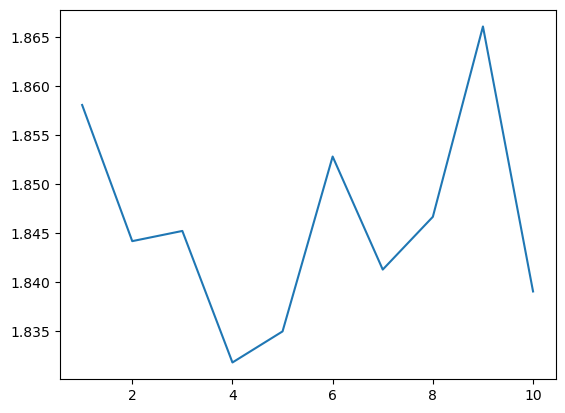

In [41]:
epochs = 10

losses = train(model, train_data_emory , epochs, device)

## it quite affects the predictions...
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [46]:
def compute_test_loss(model,loss_fn,data_loader,device,itos):
  model.eval()
  losses = []
  accs = []
  preds = [] ## predictions will be here
  prec = 0
  trues = [] ## true values will be here
  words = []

  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'texts' : batch['texts'].view(-1).to(device),
             'emotions': batch['emotions'].view(-1).to(device),
             'target_texts': batch['target_texts'].view(-1).to(device),
             'target_emotions': batch['target_emotions'].view(-1).to(device)}
    hidden = torch.zeros(80, requires_grad=True).to(device)
    inp_emotion = batch['emotions'][0]

    for t in range(len(batch['texts'])):
      inp_token = batch['texts'][t]
      target_token = batch['target_texts'][t]
      target_emotion = batch['target_emotions'][t]
      pt , pe, hidden = model.forward(inp_token,inp_emotion,hidden)
      loss1 = loss_fn(pe,target_emotion) + loss_fn(pt,target_token)
      pe = torch.argmax(pe)
      inp_emotion = pe
      words.append(itos[target_token.item()] if target_token.item() in itos else '<unk>')
      preds.append(pe.item())
      trues.append(target_emotion.item())
      if pe == target_emotion:
        accs.append(1)
      else:
        accs.append(0)
      losses.append(loss1.item())
  
  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds, words

In [47]:
trues, preds, words = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader_emory,device,itos_emory)

  0%|          | 0/85 [00:00<?, ?it/s]

average loss:  10.82054160789359
average acc:  0.2391876645355397


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
names = [f'{i}' for i in range(0,8)]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
print(confusion_matrix(trues,preds))

## to visually see how it compares:
l_ = {e:t for (t,e) in lookup_emory.items()}

l_[7] = "NE"
x1 = list(map(lambda e : l_[e],trues[:1000]))
x2 = list(map(lambda e : l_[e],preds[:1000]))
print(l_)
for a,b,c in zip(x1,x2,words[:1000]):
  print(f"word: {c} -- emotion: {a} -- predition: {b}")

              precision    recall  f1-score   support

           0       0.17      0.16      0.17      1729
           1       0.17      0.29      0.21      3130
           2       0.31      0.55      0.39      3680
           3       0.34      0.26      0.29      2729
           4       0.22      0.04      0.07      1621
           5       0.12      0.08      0.09      2383
           6       0.27      0.14      0.19      2098
           7       0.00      0.00      0.00      1243

    accuracy                           0.24     18613
   macro avg       0.20      0.19      0.18     18613
weighted avg       0.22      0.24      0.21     18613

[[ 275  401  706  168    0  137   42    0]
 [ 330  895 1215  171  135  314   70    0]
 [ 125  878 2028  112   34  329  174    0]
 [ 209  704  603  699    3  317  194    0]
 [ 303  312  505  231   71   76  123    0]
 [ 166  852  770  247   47  185  116    0]
 [  78  907  367  329    2  116  299    0]
 [ 100  349  446  118   30  114   86    0]]
{0: 

/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
